**RESNET ARCHITECTURE**

![ResNet Model](https://www.researchgate.net/profile/Muhammad_Hasan19/publication/323063171/figure/fig1/AS:603178554904576@1520820382219/Proposed-Modified-ResNet-18-architecture-for-Bangla-HCR-In-the-diagram-conv-stands-for.png)

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL
import skimage as sk
import random

In [2]:
from PIL import Image
def prepare_dataset(path):
    #declare arrays
    x=[]
    y=[]
    
    #start to push images and labels to declared arrays
    data_folders = os.listdir(path)
    for folder in data_folders:
        full_path = os.path.join(path,folder)
        for img in os.listdir(full_path):
            image = Image.open(os.path.join(full_path,img)).convert('L') #convert readed image to grayscale
            image = image.resize((224,224),Image.ANTIALIAS)
            x.append(np.asarray(image))
            if('non' in full_path): #if non hemmorhage, result is 0
                y.append(0)
            else:
                y.append(1)
            
    x = np.asarray(x)
    y = np.asarray(y)
    
    
    return (x,y)
                    

(x_train,y_train) = prepare_dataset('../input/brain tumor images dataset/Brain Tumor Images Dataset/training_set/')
(x_test,y_test) = prepare_dataset('../input/brain tumor images dataset/Brain Tumor Images Dataset/test_set/')
(x_validation,y_validation) = prepare_dataset('../input/brain tumor images dataset/Brain Tumor Images Dataset/validation_set/')

#Shapes
print("Shape of x_train {}\nShape of x_test{}\nShape of x_validation{}".format(x_train.shape,x_test.shape,x_validation.shape))

Shape of x_train (140, 224, 224)
Shape of x_test(20, 224, 224)
Shape of x_validation(40, 224, 224)


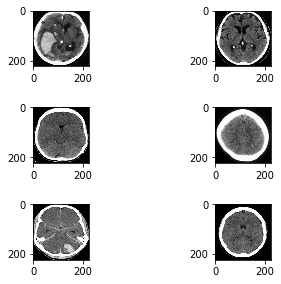

In [3]:
#random examples from x_train
def random_example(x,y,rows,cols):
    row = 0
    col = 0
    f, axarr = plt.subplots(rows,cols)

    for i in range(3):
        for k in range(2):  
            rnd = random.randint(0,len(x))
            axarr[row,col].imshow(x[rnd],cmap='gray')
            if(y is not None):
                axarr[row,col].set_title("Has Tumor" if y[rnd] == 1 else "No Tumor")
            col += 1
        col = 0
        row += 1
        
    #f.subplots_adjust(wspace=5)
    f.tight_layout(pad=0.9,h_pad=2.0)

    plt.show()
    
random_example(x_train,None,3,2)

In [4]:
#Data Augmentation
class Augmentation:
    def __init__(self):
        pass
        
    def random_rotation(self,data,label):
        # pick a random degree of rotation between 25% on the left and 25% on the right
        augmented_images = []
        augmented_label = []
        random_degree = random.uniform(-25, 25)
        counter = 0
        for img in data:
            img = sk.transform.rotate(img, random_degree)
            augmented_images.append(img)
            augmented_label.append(label[counter])
            counter += 1
        return (augmented_images,augmented_label)
    
    # add random noise to the image
    def random_noise(self,data,label):
        augmented_images = []
        augmented_label = []
        counter = 0
        for img in data:
            img = sk.util.random_noise(img)
            augmented_images.append(img)
            augmented_label.append(label[counter])
            counter += 1
        
        return (augmented_images,augmented_label)

    def horizontal_flip(self,data,label):
        # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
        counter = 0
        augmented_images = []
        augmented_label = []
        for img in data:
            img = img[:, ::-1]
            augmented_images.append(img)
            augmented_label.append(label[counter])
            counter += 1
        return (augmented_images,augmented_label)
    
    def vertical_flip(self,data,label):
        counter = 0
        augmented_images = []
        augmented_label = []
        for img in data:
            img = np.flip(img)
            augmented_images.append(img)
            augmented_label.append(label[counter])
            counter += 1
        return (augmented_images,augmented_label)
    
   

AUG = Augmentation()

(x_noise,y_noise) = AUG.random_noise(x_train,y_train)
(x_h_flipped,y_h_flipped) = AUG.horizontal_flip(x_train,y_train)
(x_v_flipped,y_v_flipped) = AUG.vertical_flip(x_train,y_train)
(x_rotated,y_rotated) = AUG.random_rotation(x_train,y_train)


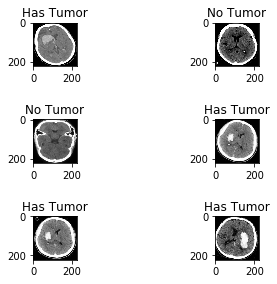

In [5]:
#concat data 

x_noise = np.asarray(x_noise)
x_h_flipped = np.asarray(x_h_flipped)
x_v_flipped = np.asarray(x_v_flipped)
x_rotated = np.asarray(x_rotated)

x_train = np.concatenate((x_train,x_noise,x_h_flipped,x_v_flipped,x_rotated),axis=0)

#----------------------------------------------------------------------------------------------------------------------------------------------------------------

y_noise = np.asarray(y_noise)
y_h_flipped = np.asarray(y_h_flipped)
y_v_flipped = np.asarray(y_v_flipped)
y_rotated = np.asarray(y_rotated)

y_train = np.concatenate((y_train,y_noise,y_h_flipped,y_v_flipped,y_rotated),axis=0)

random_example(x_train,y_train,3,2)

In [6]:
#convert np arrays to tensors
import torch

x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)

y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)


train = torch.utils.data.TensorDataset(x_train,y_train) 
train_loader = torch.utils.data.DataLoader(train,batch_size=4,shuffle=True) 

test = torch.utils.data.TensorDataset(x_test,y_test)
test_loader = torch.utils.data.DataLoader(test,batch_size=4,shuffle=False)


**An example for BasicBlock**
![BasicBlock](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

#Resnet Architecture

def conv3x3(in_planes,out_planes,stride=1):
    return nn.Conv2d(in_planes,out_planes,kernel_size=3,stride=stride,padding=1,bias=False)

def conv1x1(in_planes,out_planes,stride=1):
    return nn.Conv2d(in_planes,out_planes,kernel_size=1,stride=stride,bias=False)

class BasicBlock(nn.Module): 

    expansion = 1

    def __init__(self,inplanes,planes,stride=1,downsample=None): #planes for output
        super(BasicBlock,self).__init__()
        self.conv1 = conv3x3(inplanes,planes,stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(0.5)
        self.conv2 = conv3x3(planes,planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self,x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out= self.relu(out)
        out = self.drop(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.drop(out)

        if(self.downsample is not None):
            identity = self.downsample(x)
        out += identity 
        out = self.relu(out)

        return out


In [8]:
num_classes = 2
class ResNet(nn.Module):

    def __init__(self,block,layers,num_classes=num_classes):
        super(ResNet,self).__init__()
        self.inplanes = 64 # according to research paper
        self.conv1 = nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3,stride=2,padding=1)
        self.layer1 = self._make_layer(block,64,layers[0],stride=1)
        self.layer2 = self._make_layer(block,128,layers[1],stride=2)
        self.layer3 = self._make_layer(block,256,layers[2],stride=2)
        self.layer4 = self._make_layer(block,512,layers[3],stride=2)
        
        self.avgpooling = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*block.expansion,num_classes)

        for m in self.modules(): 
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode="fan_out",nonlinearity="relu") 
            elif isinstance(m,nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self,block,planes,num_layers,stride = 1):
        downsample = None
        if stride!=1 or self.inplanes != planes*block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes,planes*block.expansion,stride),
                nn.BatchNorm2d(planes*block.expansion)
            )
        layers = []
        layers.append(block(self.inplanes,planes,stride,downsample))
        self.inplanes = planes*block.expansion
        for _ in range(1,len(layers)):
            layers.append(block(self.inplanes,planes))

        return nn.Sequential(*layers)

    def forward(self,x):
        x= self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x=self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpooling(x)

        x = x.view(x.size(0),-1) #flatten
        x = self.fc(x)

        return x

In [9]:
#resnet 50
#model = ResNet(BottleNeck,[3,4,6,3])

#resnet 18
model = ResNet(BasicBlock,[2,2,2,2],num_classes=2)
model.cuda()
device = torch.device("cuda")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),0.0001) #0.0001 is learning rate

total_step = len(train_loader)
loss_list = []
train_acc = []
test_acc = []
batch_size = 4
for epoch in range(300):
    for i,data in enumerate(train_loader,0): #enumarete train_loader ve 0
        # i --->index , data ----> image
        inputs,labels= data
        try:
            inputs = inputs.view(batch_size,1,224,224)
            inputs = inputs.float()
        except:
            continue
        
        
        if torch.cuda.is_available():
            inputs,labels = inputs.to(device),labels.to(device)

        #zero gradient
        optimizer.zero_grad()

        #forward
        outputs = model(inputs)
        #loss
        loss = criterion(outputs,labels) #compare outputs and labels
        #backward
        loss.backward()
        #update weigths
        optimizer.step()
        if(i==(len(x_train)/batch_size)-1 and epoch%10 == 0):
            print("Epoch : {}".format(epoch))
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in train_loader:
            images,labels = data
            try:
                images = images.view(batch_size,1,224,224)
                images = images.float()
            except:
                continue #throws error because of dataset but it's not a problem to continue
            
            if torch.cuda.is_available():
                images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _,predicted = torch.max(outputs.data,1) #returns max value index
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc.append((100*correct/total))
        loss_list.append(loss.item())
        if(epoch % 10 == 0):
            print("Accuracy train: ",(100*correct/total))
            

Epoch : 0
Accuracy train:  58.714285714285715
Epoch : 10
Accuracy train:  65.71428571428571
Epoch : 20
Accuracy train:  69.28571428571429
Epoch : 30
Accuracy train:  68.42857142857143
Epoch : 40
Accuracy train:  73.28571428571429
Epoch : 50
Accuracy train:  79.28571428571429
Epoch : 60
Accuracy train:  76.0
Epoch : 70
Accuracy train:  81.28571428571429
Epoch : 80
Accuracy train:  80.0
Epoch : 90
Accuracy train:  81.57142857142857
Epoch : 100
Accuracy train:  82.85714285714286
Epoch : 110
Accuracy train:  82.85714285714286
Epoch : 120
Accuracy train:  84.57142857142857
Epoch : 130
Accuracy train:  81.57142857142857
Epoch : 140
Accuracy train:  84.28571428571429
Epoch : 150
Accuracy train:  82.14285714285714
Epoch : 160
Accuracy train:  84.28571428571429
Epoch : 170
Accuracy train:  83.28571428571429
Epoch : 180
Accuracy train:  84.28571428571429
Epoch : 190
Accuracy train:  84.0
Epoch : 200
Accuracy train:  84.42857142857143
Epoch : 210
Accuracy train:  83.85714285714286
Epoch : 220
Acc

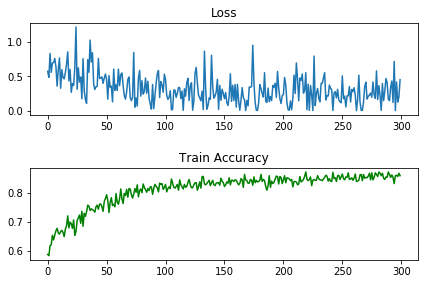

In [10]:
plt.subplot(2, 1, 1)
plt.plot(loss_list)
plt.title("Loss")

plt.subplot(2, 1, 2)
plt.plot(np.array(train_acc)/100,label="Train Accuracy",color='green')
plt.title("Train Accuracy")

plt.tight_layout(pad=0.9,h_pad=2.0)

plt.show()


In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images,labels = data
        try:
            images = images.view(batch_size,1,224,224)
            images = images.float()
        except:
            continue

        if torch.cuda.is_available():
            images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _,predicted = torch.max(outputs.data,1) #returns max value index
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_acc.append((100*correct/total))

print("Test Accuracy: ",sum(test_acc)/len(test_acc))


Test Accuracy:  84.16666666666666
